In [6]:
import nibabel
import numpy as np
import pandas as pd
import nilearn.datasets
import nilearn.image
import nilearn.plotting


import xml.etree.ElementTree as ET
import json
from neurolang.frontend import NeurolangPDL, ExplicitVBR, ExplicitVBROverlay
from rdflib import RDFS

from typing import Callable, Iterable

In [3]:
iobc = nilearn.datasets.utils._fetch_files(
    nilearn.datasets.utils._get_dataset_dir('IOBC'),
    [
        (
            'iobc.xrdf',
            'http://data.bioontology.org/ontologies/IOBC/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'iobc.xrdf'}
        )
    ]
)[0]

In [4]:
nl = NeurolangPDL()
nl.load_ontology(iobc)

In [9]:
# NeuroSynth
mni_mask = nilearn.image.resample_img(
    nibabel.load(nilearn.datasets.fetch_icbm152_2009()["gm"]),
    np.eye(3) * 2
)

ns_database_fn, ns_features_fn = nilearn.datasets.utils._fetch_files(
    "neurolang",
    [
        (
            "database.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
        (
            "features.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
    ],
)

ns_database = pd.read_csv(ns_database_fn, sep="\t")
ns_database = ns_database[["x", "y", "z", "id"]]

ns_features = pd.read_csv(ns_features_fn, sep="\t")
ns_docs = ns_features[["pmid"]].drop_duplicates()
ns_terms = pd.melt(
    ns_features, var_name="term", id_vars="pmid", value_name="TfIdf"
).query("TfIdf > 1e-3")[["term", "pmid"]]


terms_det = nl.add_tuple_set(
        ns_terms.term.unique(), name='terms_det'
)

In [90]:
ns_terms[ns_terms.term == 'pet']

,term,pmid
30969510,pet,9391021
30969514,pet,9491989
30969562,pet,10506099
30969564,pet,10545400
30969566,pet,10554992
...,...,...
30983759,pet,29530489
30983765,pet,29550938
30983832,pet,29709628
30983837,pet,29725947


In [27]:
label = nl.new_symbol(name=str(RDFS.label))
related = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#related')
altLabel = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#altLabel')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))

@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

@nl.add_symbol
def agg_create_region_overlay_MNI(
    x: Iterable, y: Iterable, z: Iterable, p: Iterable
) -> ExplicitVBR:
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return ExplicitVBROverlay(
        voxels, mni_mask.affine, p, image_dim=mni_mask.shape
    )

@nl.add_symbol
def mean(iterable: Iterable) -> float:
    return np.mean(iterable)


@nl.add_symbol
def std(iterable: Iterable) -> float:
    return np.std(iterable)

In [10]:
with nl.scope as e:
    e.ontology_related[e.ne, e.l] = (
        label(e.e, e.ne) &
        related(e.e, e.r) &
        label(e.r, e.nr) &
        (e.l == word_lower[e.nr])
    )
    
    e.ontology_synonym[e.ne, e.l] = (
        label(e.e, e.ne) &
        altLabel(e.e, e.r) &
        (e.l == word_lower[e.r])
    )
    
    e.res[e.entity, e.relation, e.term] = (
        e.ontology_related[e.entity, e.term] &
        e.terms_det[e.entity] &
        e.terms_det[e.term] &
        (e.relation == 'related')
    )
    
    e.res[e.entity, e.relation, e.term] = (
        e.ontology_synonym[e.entity, e.term] &
        e.terms_det[e.entity] &
        e.terms_det[e.term] &
        (e.relation == 'synonym')
    )
    
    res = nl.solve_all()

In [76]:
result = res['res'].as_pandas_dataframe()

In [77]:
related = result[result.relation == 'related']
related = related[related['entity'] != related['term']]

In [78]:
synonym = result[result.relation == 'synonym']
synonym = synonym[synonym['entity'] != synonym['term']]

In [83]:
hash_synonym = {}
for entity, term in synonym[['entity', 'term']].values:
    
    cut = synonym[synonym.entity == entity].term.values
    all_terms = np.append(cut, entity)
    all_terms.sort()
    #hash_term = '_'.join(all_terms)
    
    if entity in hash_synonym.keys():
        lst = hash_synonym[entity]
        for e in all_terms:
            if entity not in lst:
                lst.append(e)
            hash_synonym[entity] = lst
    else:
        hash_synonym[entity] = all_terms

hash_related = {}
for entity, term in related[['entity', 'term']].values:
    
    cut = related[related.entity == entity].term.values
    all_terms = np.append(cut, entity)
    all_terms.sort()
    #hash_term = '_'.join(all_terms)
    
    if entity in hash_related.keys():
        lst = hash_related[entity]
        for e in all_terms:
            if entity not in lst:
                lst.append(e)
            hash_related[entity] = lst
    else:
        hash_related[entity] = all_terms

In [202]:
thr_val = 95

out = []

with pd.HDFStore('neuro_paper_single_terms.hdf') as hdf:
    terms = hdf.keys()
    for t in terms:
        h_key = t[1:]
        single_term = hdf.get(t)
        single_term = single_term.groupby(['x', 'y', 'z']).std()[['p']]
        thr = np.percentile(single_term.p[single_term.p > 0], thr_val)
        single_term = single_term[single_term.p > thr]
        
        syn = False
        rel = False
        with pd.HDFStore('neuro_paper_synonym_results.hdf') as hdf2:
            synonym_keys = hdf2.keys()
            if t in synonym_keys:
                synonym = hdf2.get(t)
                synonym = synonym.groupby(['x', 'y', 'z']).std()[['p']]
                thr = np.percentile(synonym.p[synonym.p > 0], thr_val)
                synonym = synonym[synonym.p > thr]
                
                syn = True
                
            hdf2.close()
            
        with pd.HDFStore('neuro_paper_related_results.hdf') as hdf2:
            related_keys = hdf2.keys()
            if t in related_keys:
                related = hdf2.get(t)
                related = related.groupby(['x', 'y', 'z']).std()[['p']]
                thr = np.percentile(related.p[related.p > 0], thr_val)
                related = related[related.p > thr]
                rel = True
                
            hdf2.close()
            
            
        if syn:
            df = single_term.join(synonym, lsuffix=f'_term', rsuffix=f'_syn')
            df['res_std'] =  df['p_term'] - df['p_syn']
            m = len(df[df["res_std"] < 0])
            p = len(df[df["res_std"] > 0])
            e = len(df[df["res_std"] == 0])
            
            out.append((h_key, 'synonym', hash_synonym[h_key], m, p, e, 1 if p < m else 0))
            #print(f'Synonym: {h_key} vs {hash_synonym[h_key]}')
            #print(f'std < syn: {m}, std term > syn: {p}, eq: {e}', ':)' if p < m else '')
            
            
        if rel:
            df = single_term.join(related, lsuffix=f'_term', rsuffix=f'_rel')
            df['res_std'] =  df['p_term'] - df['p_rel']
            m = len(df[df["res_std"] < 0])
            p = len(df[df["res_std"] > 0])
            e = len(df[df["res_std"] == 0])
    
            out.append((h_key, 'related', hash_related[h_key], m, p, e, 1 if p < m else 0))
            #print(f'Related: {h_key} vs {hash_related[h_key]}')
            #print(f'std term < rel: {m}, std term > rel: {p}, eq: {e}', ':)' if p < m else '')
            
            
        #print('--')

In [203]:
dfo = pd.DataFrame(out, columns=['term', 'type', 'association', '<0', '>0', '==', 'valid'])

In [204]:
dfo[dfo.valid == 1]

,term,type,association,<0,>0,==,valid
5,accumbens,synonym,"[accumbens, nucleus accumbens]",4326,395,0,1
10,age,synonym,"[age, aging]",5715,2632,0,1
17,anisotropy,related,"[anisotropy, fractional anisotropy]",3248,65,0,1
23,callosum,synonym,"[callosum, corpus callosum]",3017,0,2,1
38,corpus callosum,synonym,"[callosum, corpus callosum]",3017,0,2,1
127,resting,synonym,"[rest, resting]",4628,3039,0,1
137,skin,related,"[skin, skin conductance]",2375,958,0,1
152,tactile,synonym,"[tactile, touch]",2199,1542,0,1
155,tensor,related,"[dti, tensor]",2437,807,0,1
172,visual,synonym,"[vision, visual]",6016,4587,0,1


In [205]:
dfo[dfo.valid == 0].head(25)

,term,type,association,<0,>0,==,valid
0,abnormalities,synonym,"[abnormalities, abnormality]",1644,4979,0,0
1,abnormality,synonym,"[abnormalities, abnormality]",0,1093,0,0
2,absence,synonym,"[absence, deprivation, lack]",916,4080,0,0
3,access,synonym,"[access, stroke]",36,3070,0,0
4,access,related,"[access, epilepsy]",51,3315,0,0
6,adaptation,related,"[adaptation, evolution]",517,4437,0,0
7,addiction,related,"[addiction, dependence]",46,1942,0,0
8,administration,synonym,"[administration, dose, medication]",2,2978,0,0
9,adolescent,synonym,"[adolescent, young, youth]",3,2008,0,0
11,age,related,"[age, aging, development, growing]",2658,5125,0,0


In [206]:
dfo[dfo.term == 'age']

,term,type,association,<0,>0,==,valid
10,age,synonym,"[age, aging]",5715,2632,0,1
11,age,related,"[age, aging, development, growing]",2658,5125,0,0


In [207]:
dfo[dfo.term == 'aging']

,term,type,association,<0,>0,==,valid
12,aging,synonym,"[age, aging]",7,4889,0,0
13,aging,related,"[age, aging, development, growing]",14,3635,0,0


In [208]:
import itertools
from neurolang.regions import region_union
from statsmodels.stats.multitest import multipletests
import scipy

out2 = {}

with pd.HDFStore('neuro_paper_single_terms.hdf') as hdf:
    terms = hdf.keys()
    for t in terms:
        
        h_key = t[1:]
        single_term = hdf.get(t)
        #single_term = single_term.groupby(['x', 'y', 'z']).mean()[['p']]
        thr = np.percentile(single_term.p[single_term.p > 0], thr_val)
        single_term = single_term[single_term.p > thr].set_index(['x', 'y', 'z', 'f'])
        
        syn = False
        rel = False
        with pd.HDFStore('neuro_paper_synonym_results.hdf') as hdf2:
            synonym_keys = hdf2.keys()
            if t in synonym_keys:
                synonym = hdf2.get(t)
                #synonym = synonym.groupby(['x', 'y', 'z']).mean()[['p']]
                thr = np.percentile(synonym.p[synonym.p > 0], thr_val)
                synonym = synonym[synonym.p > thr].set_index(['x', 'y', 'z', 'f'])
                syn = True
                
            hdf2.close()
            
        with pd.HDFStore('neuro_paper_related_results.hdf') as hdf2:
            related_keys = hdf2.keys()
            if t in related_keys:
                related = hdf2.get(t)
                #related = related.groupby(['x', 'y', 'z']).mean()[['p']]
                thr = np.percentile(related.p[related.p > 0], thr_val)
                related = related[related.p > thr].set_index(['x', 'y', 'z', 'f'])
                rel = True
                
            hdf2.close()
            
        
        if syn:
            df = single_term.join(synonym, lsuffix=f'_term', rsuffix=f'_syn')
            df = df.dropna(axis=0)
            gp = df.groupby(['x', 'y', 'z'])
    
            res = []
            for g in gp:
                s = g[1][f'p_term'].values 
                w = g[1][f'p_syn'].values
                l = scipy.stats.levene(s, w)
                res.append((g[0], l[0], l[1]))

            df2 = pd.DataFrame(res, columns=['voxel', 'statistic', 'pvalue'])
            df2 = df2.dropna(axis=0)
            
            mtest = multipletests([p.pvalue for p in df2.itertuples()], method='fdr_bh')
            df2['corrected_pvalue'] = mtest[1]
            out2[f'{h_key}_synonym'] = df2

        
        if rel:
            df = single_term.join(related, lsuffix=f'_term', rsuffix=f'_rel')
            df = df.dropna(axis=0)
            gp = df.groupby(['x', 'y', 'z'])
    
            res = []
            for g in gp:
                s = g[1][f'p_term'].values 
                w = g[1][f'p_rel'].values
                l = scipy.stats.levene(s, w)
                res.append((g[0], l[0], l[1]))

            df2 = pd.DataFrame(res, columns=['voxel', 'statistic', 'pvalue'])
            df2 = df2.dropna(axis=0)
            
            mtest = multipletests([p.pvalue for p in df2.itertuples()], method='fdr_bh')
            df2['corrected_pvalue'] = mtest[1]
            out2[f'{h_key}_related'] = df2

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W

In [209]:
out2.keys()

dict_keys(['abnormalities_synonym', 'abnormality_synonym', 'absence_synonym', 'access_synonym', 'access_related', 'accumbens_synonym', 'adaptation_related', 'addiction_related', 'administration_synonym', 'adolescent_synonym', 'age_synonym', 'age_related', 'aging_synonym', 'aging_related', 'anatomy_related', 'animal_synonym', 'animal_related', 'anisotropy_related', 'anxiety_synonym', 'anxiety_related', 'arterial_related', 'biomarker_synonym', 'body_related', 'callosum_synonym', 'changing_synonym', 'childhood_related', 'children_related', 'cingulate cortex_synonym', 'cingulate gyrus_synonym', 'cluster_synonym', 'cognitive function_synonym', 'cognitive function_related', 'cognitive performance_synonym', 'cognitive performance_related', 'cognitive task_synonym', 'consumption_related', 'contrast_related', 'control group_synonym', 'corpus callosum_synonym', 'dependence_related', 'deprivation_synonym', 'development_synonym', 'development_related', 'differentiation_synonym', 'diffusion tensor_

In [176]:
from neurolang import frontend as fe

def create_region(x, y, z, it):
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)

<ipython-input-195-302951e6b1b5>:22: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


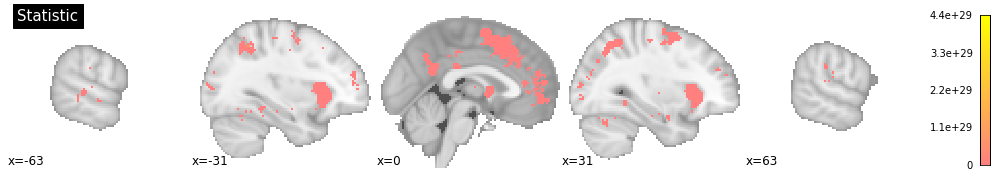

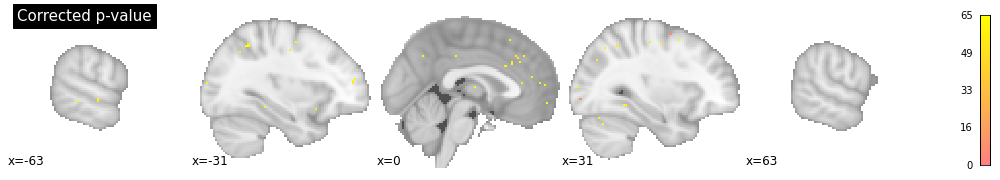

In [195]:
regions = []
vox_prob = []

for v, s, p, cp in out2['age_synonym'].values:
    x, y, z = v
    r_overlay = create_region(x, y, z, mni_mask)
    vox_prob.append((r_overlay.voxels, s, cp))
    regions.append(r_overlay)

regions = region_union(regions)

p_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)

s_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)
for v, s, cp in vox_prob:
    s_img.dataobj[tuple(v.T)] = s
    if cp < 0.05:
        p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


nilearn.plotting.plot_stat_map(
    s_img, 
    title=f'Statistic', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)
nilearn.plotting.plot_stat_map(
    p_img, 
    title=f'Corrected p-value', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)


nilearn.plotting.show()

<ipython-input-196-543efc788131>:22: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


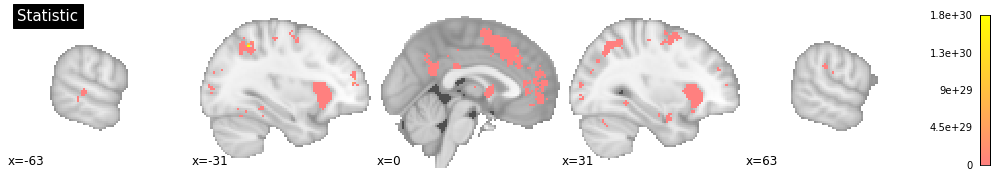

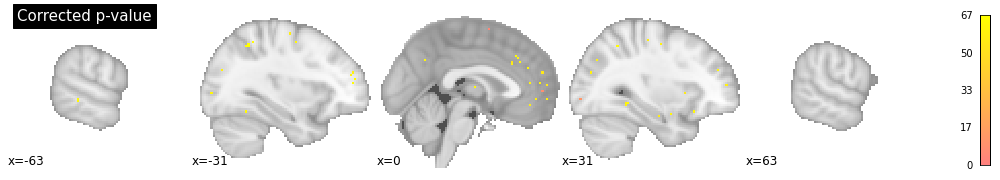

In [196]:
regions = []
vox_prob = []

for v, s, p, cp in out2['age_related'].values:
    x, y, z = v
    r_overlay = create_region(x, y, z, mni_mask)
    vox_prob.append((r_overlay.voxels, s, cp))
    regions.append(r_overlay)

regions = region_union(regions)

p_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)

s_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)
for v, s, cp in vox_prob:
    s_img.dataobj[tuple(v.T)] = s
    if cp < 0.05:
        p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


nilearn.plotting.plot_stat_map(
    s_img, 
    title=f'Statistic', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)
nilearn.plotting.plot_stat_map(
    p_img, 
    title=f'Corrected p-value', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)


nilearn.plotting.show()

<ipython-input-197-0a760933d109>:22: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


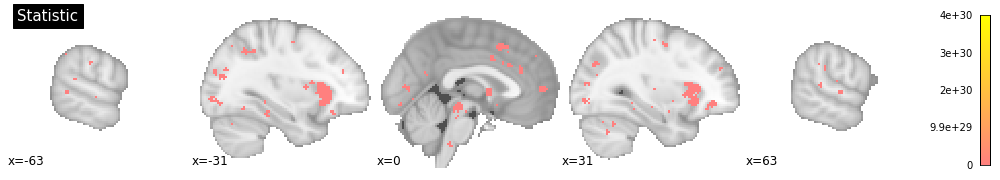

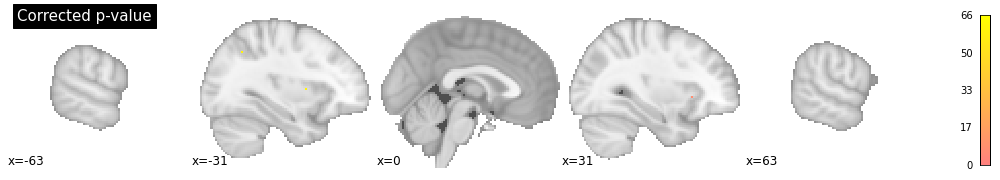

In [197]:
regions = []
vox_prob = []

for v, s, p, cp in out2['animal_synonym'].values:
    x, y, z = v
    r_overlay = create_region(x, y, z, mni_mask)
    vox_prob.append((r_overlay.voxels, s, cp))
    regions.append(r_overlay)

regions = region_union(regions)

p_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)

s_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)
for v, s, cp in vox_prob:
    s_img.dataobj[tuple(v.T)] = s
    if cp < 0.05:
        p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


nilearn.plotting.plot_stat_map(
    s_img, 
    title=f'Statistic', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)
nilearn.plotting.plot_stat_map(
    p_img, 
    title=f'Corrected p-value', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)


nilearn.plotting.show()

<ipython-input-198-70ca898bf446>:22: RuntimeWarning: divide by zero encountered in log
  p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


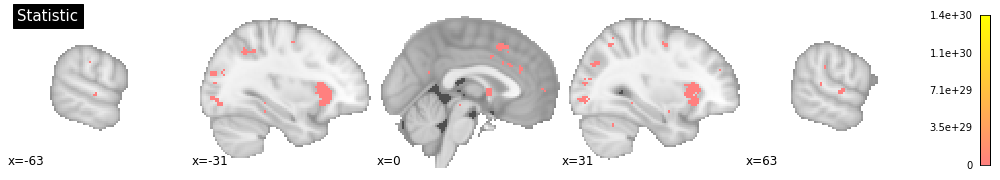

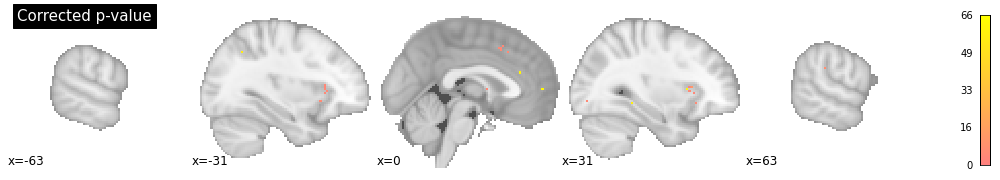

In [198]:
regions = []
vox_prob = []

for v, s, p, cp in out2['animal_related'].values:
    x, y, z = v
    r_overlay = create_region(x, y, z, mni_mask)
    vox_prob.append((r_overlay.voxels, s, cp))
    regions.append(r_overlay)

regions = region_union(regions)

p_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)

s_img = nibabel.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
)
for v, s, cp in vox_prob:
    s_img.dataobj[tuple(v.T)] = s
    if cp < 0.05:
        p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


nilearn.plotting.plot_stat_map(
    s_img, 
    title=f'Statistic', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)
nilearn.plotting.plot_stat_map(
    p_img, 
    title=f'Corrected p-value', 
    display_mode='x',
    cmap='spring',
    cut_coords=np.linspace(-63, 63, 5),
)


nilearn.plotting.show()